In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
infos = pd.read_csv('../../data/infos.csv', sep = '|')

In [3]:
items = pd.read_csv('../../data/items.csv', sep = '|')

In [4]:
orders = pd.read_csv('../../data/orders.csv', sep = '|', parse_dates=['time'])

## - Creating the structure

In [5]:
# We want the 14 dats between June 16 and June 29 to be the week pair -1
print((pd.Series(['2018-06-30 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

print((pd.Series(['2018-06-29 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

print((pd.Series(['2018-06-16 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

print((pd.Series(['2018-06-15 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

0    0
dtype: int64
0   -1
dtype: int64
0   -1
dtype: int64
0   -2
dtype: int64


In [6]:
df = orders.copy()

In [7]:
df['weekpair'] = (df.time.dt.dayofyear + 1) // 14 - 13

In [8]:
df.weekpair.max(), df.weekpair.min()

(-1, -13)

In [9]:
npairs = df.weekpair.nunique()

In [10]:
n_items = items['itemID'].nunique()
print('total number of items:', n_items)
print('expected number of instances:', n_items * npairs)

total number of items: 10463
expected number of instances: 136019


In [11]:
mi = pd.MultiIndex.from_product([range(-npairs, 0), items['itemID']], names=['weekpair', 'itemID'])
data_temp = pd.DataFrame(index = mi)

In [12]:
data_temp = data_temp.join(df.groupby(['weekpair', 'itemID'])[['order']].sum(), how = 'left')

In [13]:
data_temp.fillna(0, inplace = True)

In [14]:
data_temp.groupby('itemID').count().min()

order    13
dtype: int64

In [15]:
data_temp

order
weekpair itemID       
-13      1         0.0
         2         0.0
         3         1.0
         4         0.0
         5         2.0
...                ...
-1       10459     0.0
         10460     0.0
         10461     0.0
         10462     0.0
         10463     0.0

[136019 rows x 1 columns]

## - Creating features

In [16]:
data = data_temp.reset_index()

In [17]:
items.head(2)

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92


In [18]:
# data = pd.merge(data, items[['itemID', 'manufacturer', 'category1', 'category2', 'category3']], on = 'itemID')
data = pd.merge(data, items, on = 'itemID')

In [19]:
data.sort_values('weekpair', inplace = True)

In [20]:
data

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,-13,1,0.0,0,1,4.38,1,1,1,8.84
83304,-13,6409,0.0,0,159,0.00,5,32,4,9.59
118534,-13,9119,0.0,202,242,0.00,8,44,8,519.87
17485,-13,1346,0.0,0,35,0.00,1,5,1,28.85
52702,-13,4055,0.0,0,86,0.00,2,8,2,18.79
...,...,...,...,...,...,...,...,...,...,...
59565,-1,4582,0.0,0,127,0.00,6,19,3,4.35
76452,-1,5881,0.0,0,159,0.00,5,32,4,7.22
46682,-1,3591,4.0,74,86,0.00,2,8,2,21.66
126372,-1,9721,0.0,195,240,0.00,8,43,8,15.02


In [21]:
# features = [
#     ('itemID', 'item'),
#     ('manufacturer', 'manuf'),
#     ('category1', 'cat1'),
#     ('category2', 'cat2'),
#     ('category3', 'cat3')
# ]
# for f, n in features:
#     if f not in data.columns:
#         print('ops', f)

In [22]:
# features = [('itemID', 'item')]

In [23]:
# # f, name = ('manufacturer', 'manuf')
# for f, name in features:
#     print(f)
#     temp = data.groupby([f, 'weekpair'])[['order']].sum()
#     shifted = temp.groupby(f)[['order']].shift(1)
#     new_feature_block = pd.DataFrame()
#     for n in range(3):
#         rolled = shifted.groupby(f, as_index = False)['order'].rolling(2 ** n).mean()
#         new_feature_block['%s_%d' % (name, 2 ** n)] = rolled.reset_index(0, drop = True) # rolling has a weird index behavior...
#     data = pd.merge(data, new_feature_block.reset_index(), on = [f, 'weekpair'])

In [24]:
def gbagg(data, group_cols, targeted_cols, out_names, function, as_index = False):
  
    X = data.values
    col = {c : i for i, c in enumerate(data.columns)}

    # values that are going to calculated
    new_feat = []
    
    # numbers of the columns
    gcols = [col[c] for c in group_cols]
    tcols = [col[c] for c in targeted_cols]
    
    interval = None
    a = None
    i = 0
    while i < len(X):
        a = X[i, gcols]

        # find the whole interval of this group
        j = i
        while j < len(X):
            if (X[j, gcols] != a).any():
                break
            j += 1
        interval = X[i:j, tcols]

        # apply function on interval, save in new feature
        output = function(interval)
        new_feat.append(output)

        # go to next group
        i = j
    
    idx = data.groupby(group_cols).size().index # this is actually fast...
    out_df = pd.DataFrame(new_feat, columns = out_names, index = idx)
        
    if not as_index:
        out_df.reset_index(inplace = True)
        
    return out_df

In [25]:
def gbtransf(data, group_cols, targeted_cols, out_names, function, params = dict()):
  
    X = data.values
    col = {c : i for i, c in enumerate(data.columns)}

    # values that are going to calculated
    new_feat = np.zeros((len(data), len(out_names)))
    
    # numbers of the columns
    gcols = [col[c] for c in group_cols]
    tcols = [col[c] for c in targeted_cols]
    
    interval = None
    a = None
    i = 0
    while i < len(X):
        a = X[i, gcols]

        # find the whole interval of this group
        j = i
        while j < len(X):
            if (X[j, gcols] != a).any():
                break
            j += 1
        interval = X[i:j, tcols]

        # apply function on interval, save in new feature
        output = function(interval, **params)
        new_feat[i:j] = output

        # go to next group
        i = j
    
    out_df = pd.DataFrame(new_feat, columns = out_names, index = data.index)
        
    return out_df

In [26]:
data.sort_values(['itemID', 'weekpair'], inplace = True)

In [27]:
# gbtransf(data, ['itemID', 'weekpair'], ['order'], ['out'], lambda x : np.ones_like(x))

In [28]:
def shift_and_2n_window(x, ws):
#     out = pd.DataFrame(x)
#     out = out.shift()
#     out = out.rolling(2 ** n).mean()

    shifted = np.zeros_like(x) # output
    shifted[1:] = x[:-1] # shift
    out = np.zeros_like(x, dtype = float)
    
    # rolling mean
    total = shifted[:ws].sum()
    out[ws - 1] = total / ws
    for i in range(ws, len(out)):
        total = total - shifted[i - ws] + shifted[i]
        out[i] = total / ws
    out[:ws] = np.NaN # maybe ws -1 should be NaN as well for receiving one NaN value when ws > 1
    # out[0] = np.NaN # this is always NaN for a shift of 1
    return out

In [29]:
shift_and_2n_window(np.array([1 , 2, 3, 4, 5, 6]), 2 ** 1)

array([nan, nan, 1.5, 2.5, 3.5, 4.5])

In [30]:
features = [('itemID', 'item')]

In [31]:
for f, name in features:
    print(f)
    new_feature_block = pd.DataFrame()
    for n in range(3):
        new_f = gbtransf(data, ['itemID'], ['order'], ['out'], shift_and_2n_window, {'ws' : 2 ** n})
        new_feature_block['%s_%d' % (name, 2 ** n)] = new_f['out']
#     data = pd.merge(data, new_feature_block.reset_index(), on = [f, 'weekpair'])
    data = pd.concat([data, new_feature_block], axis =  1)

itemID


In [32]:
data.count() # the larger the window, more NaN are expected

weekpair                  136019
itemID                    136019
order                     136019
brand                     136019
manufacturer              136019
customerRating            136019
category1                 136019
category2                 136019
category3                 136019
recommendedRetailPrice    136019
item_1                    125556
item_2                    115093
item_4                     94167
dtype: int64

In [33]:
data.sort_values(['itemID', 'weekpair'], inplace = True)

In [34]:
def dist2firstvalue(x):
    out = np.zeros_like(x, dtype = float)
    first = np.NaN
    for i in range(len(x)):
        out[i] = first
        if x[i] != 0:
            first = i
            break
    if i == len(x) - 1:
        return out
    for j in range(int(first), len(x)):
        out[j] = j - first
        
    return out

In [35]:
# dist2firstvalue(np.array([0 , 0, 3, 0, 5, 6]))
dist2firstvalue(np.array([0 , 0, 0, 0]))

array([nan, nan, nan, nan])

In [36]:
def dist2lastpeak(x):
    out = np.zeros_like(x, dtype = float)
    peak = np.NaN
    peak_val = 0
    for i in range(0, len(x)):
        out[i] = i - peak
        if x[i] > peak_val:
            peak = i
            peak_val = x[i]
        
    return out

In [37]:
dist2lastpeak(np.array([0 , 0, 3, 0, 5, 6]))

array([nan, nan, nan,  1.,  2.,  1.])

In [38]:
data['dist2firstvalue'] = gbtransf(data, ['itemID'], ['order'], ['out'], dist2firstvalue)['out']
data['dist2lastpeak'] = gbtransf(data, ['itemID'], ['order'], ['out'], dist2lastpeak)['out']

In [39]:
data.fillna(-999, inplace=True)

In [40]:
# checking if we got what we wanted
data.query('itemID == 1')

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2firstvalue,dist2lastpeak
0,-13,1,0.0,0,1,4.38,1,1,1,8.84,-999.0,-999.0,-999.00,-999.0,-999.0
1,-12,1,2.0,0,1,4.38,1,1,1,8.84,0.0,-999.0,-999.00,0.0,-999.0
2,-11,1,313.0,0,1,4.38,1,1,1,8.84,2.0,1.0,-999.00,1.0,1.0
3,-10,1,35.0,0,1,4.38,1,1,1,8.84,313.0,157.5,-999.00,2.0,1.0
4,-9,1,3.0,0,1,4.38,1,1,1,8.84,35.0,174.0,87.50,3.0,2.0
5,-8,1,1.0,0,1,4.38,1,1,1,8.84,3.0,19.0,88.25,4.0,3.0
6,-7,1,1.0,0,1,4.38,1,1,1,8.84,1.0,2.0,88.00,5.0,4.0
7,-6,1,2.0,0,1,4.38,1,1,1,8.84,1.0,1.0,10.00,6.0,5.0
8,-5,1,299.0,0,1,4.38,1,1,1,8.84,2.0,1.5,1.75,7.0,6.0
9,-4,1,3.0,0,1,4.38,1,1,1,8.84,299.0,150.5,75.75,8.0,7.0


In [41]:
# data['weekswithtrans'] = data.groupby('itemID')['order'].apply(lambda x : (x > 0).cumsum()) / (data['weekpair'] + 14)

In [42]:
counts = data.groupby('itemID')['order'].apply(lambda x : (x > 0).sum())

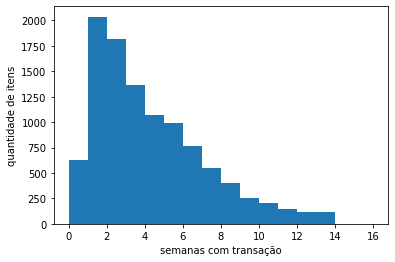

In [43]:
plt.hist(counts, bins = range(17))
plt.ylabel('quantidade de itens')
plt.xlabel('semanas com transação')
plt.show()

In [44]:
# f = 'itemID'
# temp = data.groupby([f, 'week'])[['order']].sum()
# shifted = temp.groupby(f)[['order']].shift(1)
# data['feature'] = (shifted.fillna(0) > 0).groupby(f)[['order']].cumsum().values

In [45]:
data.head()

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2firstvalue,dist2lastpeak
0,-13,1,0.0,0,1,4.38,1,1,1,8.84,-999.0,-999.0,-999.0,-999.0,-999.0
1,-12,1,2.0,0,1,4.38,1,1,1,8.84,0.0,-999.0,-999.0,0.0,-999.0
2,-11,1,313.0,0,1,4.38,1,1,1,8.84,2.0,1.0,-999.0,1.0,1.0
3,-10,1,35.0,0,1,4.38,1,1,1,8.84,313.0,157.5,-999.0,2.0,1.0
4,-9,1,3.0,0,1,4.38,1,1,1,8.84,35.0,174.0,87.5,3.0,2.0


##  - Split Data

In [46]:
filtered_data = data

In [72]:
sub_week = -1
train = filtered_data.query('-13 <= weekpair <= (@sub_week - 2)').reset_index(drop = True)
full_train = filtered_data.query('-13 <= weekpair <= (@sub_week - 1)').reset_index(drop = True)
val = filtered_data.query('weekpair == (@sub_week - 1)').reset_index(drop = True)
sub = filtered_data.query('weekpair == (@sub_week)').reset_index(drop = True)

In [73]:
len(train), len(val), len(sub)

(115093, 10463, 10463)

In [74]:
weights = infos.set_index('itemID')['simulationPrice'].to_dict()

In [75]:
train.columns

Index(['weekpair', 'itemID', 'order', 'brand', 'manufacturer',
       'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice', 'item_1', 'item_2', 'item_4',
       'dist2firstvalue', 'dist2lastpeak'],
      dtype='object')

In [76]:
y_train = train.pop('order').values
y_full_train = full_train.pop('order').values
y_val = val.pop('order').values
y_sub = sub.pop('order').values

X_train = train.values
X_full_train = full_train.values
X_val = val.values
X_sub = sub.values

w_train = train['itemID'].map(weights)
w_full_train = full_train['itemID'].map(weights)
w_val = val['itemID'].map(weights)
w_sub = sub['itemID'].map(weights)

<hr>

## - Min Expected Error

In [77]:
def evaluate(prediction, target, simulationPrice):
    return np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)

In [78]:
# max expected rmse
from sklearn.metrics import mean_squared_error as mse
# pred = data.loc[1:12].groupby('itemID')['order'].mean().sort_index()
# target_week = data.loc[13:, 'order'].reset_index(level = 0, drop = True).sort_index()
# mse(target_week, pred) ** .5

<hr>

## - XGBoost

In [79]:
import xgboost as xgb

In [80]:
xgb.__version__

'1.1.0'

In [81]:
# custom objective

def gradient(prediction, dtrain):
    y = dtrain.get_label()
#     prediction.astype(int)
#     prediction = np.minimum(prediction.astype(int), 1)
    return -2 * (prediction - np.maximum(prediction - y, 0) * 1.6) * (1 - (prediction > y) * 1.6)

def hessian(prediction, dtrain):
    y = dtrain.get_label()
#     prediction.prediction(int)
#     prediction = np.minimum(prediction.astype(int), 1)
    return -2 * (1 - (prediction > y) * 1.6) ** 2

def objective(prediction, dtrain):
    w = dtrain.get_weight()
    grad = gradient(prediction, dtrain) * w
    hess = hessian(prediction, dtrain) * w
    return grad, hess

In [82]:
# custom feval

def feval(prediction, dtrain):
    prediction = prediction.astype(int)
#     predt = np.minimum(predt.astype(int), 1)
    target = dtrain.get_label()
    simulationPrice = dtrain.get_weight()
    return 'feval', np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)

In [85]:
dtrain = xgb.DMatrix(X_train, y_train, w_train, missing = -999)
dfulltrain = xgb.DMatrix(X_full_train, y_full_train, w_full_train, missing = -999)
dval = xgb.DMatrix(X_val, y_val, w_val, missing = -999)
dsub = xgb.DMatrix(X_sub, y_sub, w_sub, missing = -999)
# specify parameters via map
param = {
    'max_depth':6,
    'eta':0.005,
    'objective':'reg:squarederror',
    'disable_default_eval_metric': 1
}
num_round = 100
bst = xgb.train(param, dtrain,
                num_round, early_stopping_rounds = 5,
#                 obj = objective,
                feval = feval, maximize = True,
                evals = [(dtrain, 'train'), (dsub, 'sub'), (dval, 'val')])

[0]	train-feval:96150.98405	sub-feval:2485.89802	val-feval:15369.26397
Multiple eval metrics have been passed: 'val-feval' will be used for early stopping.

Will train until val-feval hasn't improved in 5 rounds.
[1]	train-feval:253256.62814	sub-feval:13117.26409	val-feval:31551.96395
[2]	train-feval:474174.97027	sub-feval:14856.09011	val-feval:56174.56195
[3]	train-feval:582975.36648	sub-feval:23042.55819	val-feval:63506.64601
[4]	train-feval:697204.63869	sub-feval:27879.15025	val-feval:73912.54801
[5]	train-feval:808346.32665	sub-feval:28503.14428	val-feval:79527.06605
[6]	train-feval:949073.29680	sub-feval:41569.39236	val-feval:93931.10410
[7]	train-feval:1156689.63104	sub-feval:46493.06639	val-feval:112946.27214
[8]	train-feval:1404417.41515	sub-feval:50902.64041	val-feval:124146.97214
[9]	train-feval:1504004.03323	sub-feval:51933.99844	val-feval:128152.51620
[10]	train-feval:1558035.82927	sub-feval:54576.19447	val-feval:131315.13226
[11]	train-feval:1640820.91938	sub-feval:53264.3

In [84]:
prediction = bst.predict(dsub, ntree_limit=bst.best_ntree_limit).astype(int)
evaluate(prediction, y_sub, w_sub)

-18812.63000000008

In [91]:
bst_sub = xgb.train(param, dfulltrain,
    num_boost_round = bst.best_ntree_limit, early_stopping_rounds = 5,
    #                 obj = objective,
    feval = feval, maximize = True,
    evals = [(dfulltrain, 'ftrain')],
    verbose_eval = False,
)

In [92]:
prediction = bst_sub.predict(dsub, ntree_limit=bst_sub.best_ntree_limit).astype(int)
evaluate(prediction, y_sub, w_sub)

58722.425999999956

In [63]:
# max score
evaluate(y_sub, y_sub, w_sub)

7683293.24

In [50]:
# using previous weekpair
evaluate(y_val, y_sub, w_sub)

-18102766.566000003

In [325]:
submission = items[['itemID']].copy()
submission['demandPrediction'] = bst.predict(dsub, ntree_limit=bst.best_ntree_limit).astype(int)
submission.to_csv('../../submissions/sub_inclass_03.csv', sep = '|', index=False)
# submission.head()

<hr>

## - LGBM

In [327]:
def feval_lgbm(prediction, dtrain):
    prediction = prediction.astype(int)
    target = dtrain.get_label()
    simulationPrice = dtrain.get_weight()
    return 'feval', np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice), True

In [453]:
import lightgbm as lgb

params = {
          "objective" : 'regression_l1',
#           "metric" :"rmse",
#           "learning_rate" : 0.01,
          'verbosity': 2,
#           'max_depth': 6,
#           'num_leaves': 15,
          "min_data_in_leaf":3000
         }
# https://lightgbm.readthedocs.io/en/latest/Parameters.html


ds_params = {
#     'categorical_feature' : [8, 9, 10],
}
lgbtrain = lgb.Dataset(X_train, label = y_train, weight=w_train, **ds_params)
lgbvalid = lgb.Dataset(X_val, label = y_val, weight=w_val, **ds_params)
lgbsubmis = lgb.Dataset(X_sub, label = y_sub, weight=w_sub, **ds_params)

num_round = 1000
lgb_model = lgb.train(params,
                  lgbtrain,
                  num_round,
                  valid_sets = [lgbtrain, lgbvalid],
                  valid_names = ['train', 'val'],
                  verbose_eval=5,
                  early_stopping_rounds=5,
                 feval = feval_lgbm,
#                   fobj = objective,
                 )

Training until validation scores don't improve for 5 rounds
[5]	train's l1: 4.70706	train's feval: 90253.1	val's l1: 6.15974	val's feval: 16918.9
[10]	train's l1: 4.70098	train's feval: 229817	val's l1: 6.14635	val's feval: 45001.3
[15]	train's l1: 4.69827	train's feval: 298310	val's l1: 6.14021	val's feval: 61657.4
[20]	train's l1: 4.69715	train's feval: 340830	val's l1: 6.13818	val's feval: 68207.5
[25]	train's l1: 4.69617	train's feval: 369239	val's l1: 6.13664	val's feval: 73685.9
[30]	train's l1: 4.69561	train's feval: 383733	val's l1: 6.13623	val's feval: 75236.2
[35]	train's l1: 4.69516	train's feval: 402572	val's l1: 6.13593	val's feval: 78045
[40]	train's l1: 4.69487	train's feval: 410676	val's l1: 6.13535	val's feval: 80536.1
[45]	train's l1: 4.69465	train's feval: 424415	val's l1: 6.13502	val's feval: 84981.9
[50]	train's l1: 4.69455	train's feval: 422603	val's l1: 6.13464	val's feval: 84700.8
Early stopping, best iteration is:
[46]	train's l1: 4.69463	train's feval: 424549	

In [455]:
prediction = lgb_model.predict(X_sub, num_iteration=lgb_model.best_iteration).astype(int)
evaluate(prediction, y_sub, w_sub)

81193.40400000001

<hr>

## - CatBoost

In [363]:
from catboost import CatBoost, CatBoostRegressor, Pool

In [439]:
class feval_cat(object):
    def get_final_error(self, error, weight):
        # return error / (weight + 1e-38)
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, simulationPrice):
        prediction = np.array(approxes[0]).astype(int)
        target = np.array(target[0]).astype(int)
        simulationPrice = np.array(simulationPrice[0])
        score = np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)
#         print('score', score)
#         print(type(prediction), type(target), type(simulationPrice))
        return np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice), 0

In [448]:
ds_params = {
#     'cat_features' : [8, 9, 10],
}
train_pool = Pool(X_train, label = y_train, weight = w_train, **ds_params)
val_pool = Pool(X_val, label = y_val, weight = w_sub, **ds_params)
sub_pool = Pool(X_sub, label = y_sub, weight = w_sub, **ds_params)


model = CatBoostRegressor(
#     iterations = 2,
#     depth=6, 
#     learning_rate=0.1, 
    loss_function='MAE',
    early_stopping_rounds=5,
    eval_metric = feval_cat(),
    thread_count=-1,
)

model.fit(
    train_pool,
    eval_set=[train_pool, val_pool],
#     logging_level='Verbose',  # you can uncomment this for text output

);


score 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 66.3ms	remaining: 1m 6s
score 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
1:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 129ms	remaining: 1m 4s
score 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
2:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	be

score -13586.91626443863
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -13586.91626443863
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 23481.11954498291
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
21:	learn: -13586.9162644	test: -13586.9162644	test1: 23481.1195450	best: 23481.1195450 (20)	total: 1.42s	remaining: 1m 3s
score -14626.206284666063
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -14626.206284666063
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 25355.199508666992
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
22:	learn: -14626.2062847	test: -14626.2062847	test1: 25355.1995087	best: 25355.1995087 (22)	total: 1.49s	remaining: 1m 3s
score -15327.984298324587
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -15327.984298324587
<class 'numpy.ndarray'> <class 'numpy.ndarray'>

score -31374.210610628128
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -31374.210610628128
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 61596.598806381226
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
42:	learn: -31374.2106106	test: -31374.2106106	test1: 61596.5988064	best: 61596.5988064 (42)	total: 2.76s	remaining: 1m 1s
score -32277.672628211978
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -32277.672628211978
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 63084.838777542114
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
43:	learn: -32277.6726282	test: -32277.6726282	test1: 63084.8387775	best: 63084.8387775 (43)	total: 2.82s	remaining: 1m 1s
score -32969.160641670234
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -32969.160641670234
<class 'numpy.ndarray'> <class 'numpy.ndarra

score -43314.72684302331
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 85215.51834869385
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
62:	learn: -43314.7268430	test: -43314.7268430	test1: 85215.5183487	best: 85215.5183487 (61)	total: 4.04s	remaining: 1m
score -43314.72684302331
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -43314.72684302331
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 85215.51834869385
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
63:	learn: -43314.7268430	test: -43314.7268430	test1: 85215.5183487	best: 85215.5183487 (61)	total: 4.1s	remaining: 1m
score -43314.72684302331
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -43314.72684302331
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 85215.51834869385
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'nump

score -51499.39300231934
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 102826.35800743103
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
85:	learn: -51499.3930023	test: -51499.3930023	test1: 102826.3580074	best: 102826.3580074 (85)	total: 5.53s	remaining: 58.8s
score -52302.013017940524
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -52302.013017940524
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 103873.63798713684
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
86:	learn: -52302.0130179	test: -52302.0130179	test1: 103873.6379871	best: 103873.6379871 (86)	total: 5.6s	remaining: 58.8s
score -52404.91301994324
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -52404.91301994324
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 104094.11798286438
<class 'numpy.ndarray'> <class 'numpy.ndarray

score -58959.64314751626
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -58959.64314751626
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 117129.99773025513
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
106:	learn: -58959.6431475	test: -58959.6431475	test1: 117129.9977303	best: 117129.9977303 (106)	total: 6.87s	remaining: 57.3s
score -58959.64314751626
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -58959.64314751626
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 117129.99773025513
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
107:	learn: -58959.6431475	test: -58959.6431475	test1: 117129.9977303	best: 117129.9977303 (106)	total: 6.94s	remaining: 57.3s
score -58965.817147636415
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -58965.817147636415
<class 'numpy.ndarray'> <class 'numpy.nd

score -63954.40924472809
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -63954.40924472809
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 131306.86145553587
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
126:	learn: -63954.4092447	test: -63954.4092447	test1: 131306.8614555	best: 131306.8614555 (126)	total: 8.15s	remaining: 56s
score -63954.40924472809
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -63954.40924472809
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 131306.86145553587
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
127:	learn: -63954.4092447	test: -63954.4092447	test1: 131306.8614555	best: 131306.8614555 (126)	total: 8.21s	remaining: 56s
score -64221.94924993516
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -64221.94924993516
<class 'numpy.ndarray'> <class 'numpy.ndarray'

score -67378.92131137848
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -67378.92131137848
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 140054.405286026
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
146:	learn: -67378.9213114	test: -67378.9213114	test1: 140054.4052860	best: 140109.5252850 (144)	total: 9.46s	remaining: 54.9s
score -67687.62131738664
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -67687.62131738664
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 140230.78928260802
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
147:	learn: -67687.6213174	test: -67687.6213174	test1: 140230.7892826	best: 140230.7892826 (147)	total: 9.53s	remaining: 54.9s
score -67687.62131738664
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -67687.62131738664
<class 'numpy.ndarray'> <class 'numpy.ndarra

score -71492.86339144707
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 149061.01311149597
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
166:	learn: -71492.8633914	test: -71492.8633914	test1: 149061.0131115	best: 149061.0131115 (166)	total: 10.7s	remaining: 53.4s
score -71743.93939633369
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -71743.93939633369
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 149557.09310188293
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
167:	learn: -71743.9393963	test: -71743.9393963	test1: 149557.0931019	best: 149557.0931019 (167)	total: 10.8s	remaining: 53.3s
score -71916.81139969826
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -71916.81139969826
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 149761.0370979309
<class 'numpy.ndarray'> <class 'numpy.ndarr

score -74734.21345453263
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -74734.21345453263
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 155802.18898086547
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
188:	learn: -74734.2134545	test: -74734.2134545	test1: 155802.1889809	best: 155802.1889809 (188)	total: 12s	remaining: 51.7s
score -74734.21345453263
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -74734.21345453263
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 155802.18898086547
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
189:	learn: -74734.2134545	test: -74734.2134545	test1: 155802.1889809	best: 155802.1889809 (188)	total: 12.1s	remaining: 51.6s
score -74818.59145617487
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -74818.59145617487
<class 'numpy.ndarray'> <class 'numpy.ndarra

score -75950.49147820474
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -75950.49147820474
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 157885.72494049073
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
210:	learn: -75950.4914782	test: -75950.4914782	test1: 157885.7249405	best: 157885.7249405 (210)	total: 13.3s	remaining: 49.9s
score -76028.69547972681
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -76028.69547972681
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 158150.30093536378
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
211:	learn: -76028.6954797	test: -76028.6954797	test1: 158150.3009354	best: 158150.3009354 (211)	total: 13.4s	remaining: 49.8s
score -75991.65147900584
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -75991.65147900584
<class 'numpy.ndarray'> <class 'numpy.ndar

score -77899.41751613618
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -77899.41751613618
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 161435.4528717041
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
230:	learn: -77899.4175161	test: -77899.4175161	test1: 161435.4528717	best: 161435.4528717 (230)	total: 14.5s	remaining: 48.2s
score -77858.25751533509
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -77858.25751533509
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score 161463.01287117004
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
231:	learn: -77858.2575153	test: -77858.2575153	test1: 161463.0128712	best: 161463.0128712 (231)	total: 14.5s	remaining: 48.1s
score -78197.82752194405
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
score -78197.82752194405
<class 'numpy.ndarray'> <class 'numpy.ndarr

In [451]:
prediction = model.predict(X_val, ntree_end = model.best_iteration_).astype(int)
evaluate(prediction, y_val, w_val)

79103.158

In [452]:
prediction = model.predict(X_sub, ntree_end = model.best_iteration_).astype(int)
evaluate(prediction, y_sub, w_sub)

90124.73599999999

<hr>

## - Ensemble

In [471]:
cat_w = 1
lgb_w = 1
xgb_w = 1
ensemble = model.predict(X_sub, ntree_end = model.best_iteration_) * cat_w
ensemble += lgb_model.predict(X_sub, num_iteration=lgb_model.best_iteration) * lgb_w
ensemble += bst.predict(dsub, ntree_limit=bst.best_ntree_limit) * xgb_w
ensemble = ensemble / (cat_w + lgb_w)
evaluate(ensemble.astype(int), y_sub, w_sub)

106867.96599999999

<hr>

## - Linear Regression

In [270]:
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import 

In [271]:
lr = LinearRegression()

In [272]:
lr.fit(X_train, y_train, w_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [273]:
print('train', evaluate(lr.predict(X_train), y_train, w_train))
print('test', evaluate(lr.predict(X_test), y_test, w_test))
print('sub', evaluate(lr.predict(X_sub), y_sub, w_sub))

train -21058674.042366117
test -2602271.639547858
sub -2761693.8996196142


<hr>

In [ ]:
# fazer feature que pega o percentil de quando o item deu de dinheiro dentro de uma categoria
# fazer features que pega dist de atual até o pico mais alto
# dist do maior pico pro segundo
# min(dist(terceiro, primeiro), dist(terceiro, segundo))